In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# Create Gaussian blurs with different widths

In [2]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss,3)

for i in range(nGauss):

    # location and width parameters
    loc = np.max(x)/2 * np.random.randn(2) # center coordinate
    wid = np.random.rand()*10 + 5 # width of Gaussian

    # create the gaussian with random centers
    G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
    G  = G + np.random.randn(imgSize,imgSize)/10

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] )

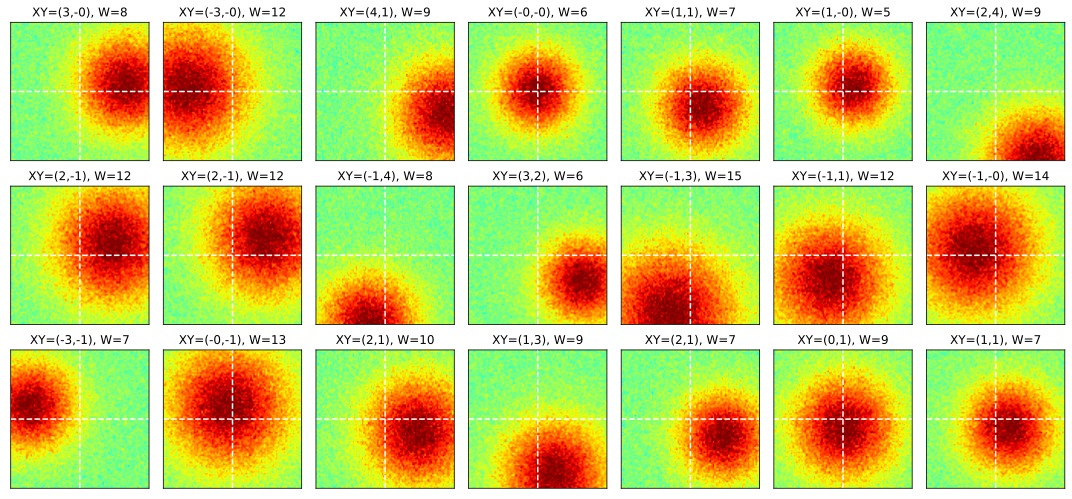

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze( images[whichpic,:,:] )
    ax.imshow(G,vmin=-1, vmax=1, cmap='jet', extent=[-4,4,-4,4], origin='upper')
    ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Create train/test groups using DataLoader

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])


# Create the DL model

In [7]:
# create a class for the model
def makeTheNet():

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            # all layers in one go using nn.Sequential
            self.enc = nn.Sequential(

                # conv/pool block 1
                nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
                nn.ReLU(),                   # 
                nn.AvgPool2d(2,2),           # output size: 91/2 = 45

                # conv/pool block 2
                nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
                nn.ReLU(),                   # 
                nn.AvgPool2d(2,2),           # output size: 45/2 = 22

                # linear decision layer
                nn.Flatten(),                # vectorize conv2 block output
                nn.Linear(22*22*4,50),       # output size: 50
                nn.Linear(50,3),             # output size: 3
            )
      
        def forward(self,x):
            return self.enc(x)
  
    # create the model instance
    net = gausnet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net,lossfun,optimizer

In [8]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print(yHat)
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[-7.6878e-02, -6.9885e-04, -4.6645e-02],
        [-1.0430e-01, -1.7256e-02, -3.4614e-02],
        [-8.8248e-02, -2.6233e-03, -3.4384e-02],
        [-9.0166e-02, -8.6659e-03, -2.9799e-02],
        [-9.0253e-02,  2.0992e-06, -3.6115e-02],
        [-8.2953e-02, -1.0504e-02, -3.0431e-02],
        [-8.1722e-02,  1.9668e-02, -3.9235e-02],
        [-7.6236e-02, -2.0906e-03, -4.6309e-02],
        [-1.0649e-01, -2.2746e-02, -4.0345e-02],
        [-8.0361e-02,  1.3722e-02, -4.2960e-02],
        [-1.0828e-01,  2.3041e-02, -2.5187e-02],
        [-1.0651e-01, -2.2770e-02, -2.7648e-02],
        [-7.3031e-02,  3.0932e-03, -4.3970e-02],
        [-8.1786e-02, -7.2421e-03, -3.9017e-02],
        [-9.8330e-02, -1.2736e-02, -2.3657e-02],
        [-8.0777e-02,  1.2527e-02, -4.4941e-02]], grad_fn=<AddmmBackward0>)
 
torch.Size([16, 3])
 
Loss:
tensor(41.8466, grad_fn=<MseLossBackward0>)


In [9]:
# count the total number of parameters in the model
summary(net, (1, imgSize, imgSize));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 3]                   153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


# Create a function that trains the model

In [10]:
# a function that trains the model

def function2trainTheModel():

    # number of epochs
    numepochs = 30

    # create a new model
    net,lossfun,optimizer = makeTheNet()

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
        # end of batch loop...

        # and get average losses across the batches
        trainLoss[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat,y)
      
        # extract the loss for this test epoch
        testLoss[epochi] = loss.item()

    # end epochs

    # function output
    return trainLoss,testLoss,net

# Run the model and show the results!

In [11]:
trainLoss,testLoss,net = function2trainTheModel()

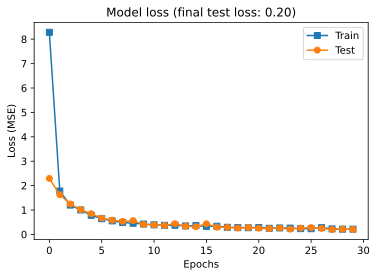

In [12]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])

plt.show()

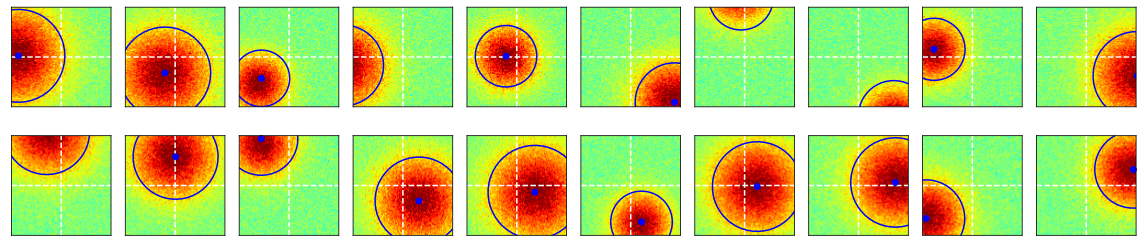

In [13]:
# visualize some images

X,Y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

    # get the Gaussian and draw it, and draw the white guide-lines
    G = torch.squeeze( X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')

    # compute the model's prediction
    cx = yHat[i][0].item() # center X
    cy = yHat[i][1].item() # center Y
    rd = yHat[i][2].item() # radius

    # and draw it
    x = cx + np.cos(th)*np.sqrt(rd)
    y = cy + np.sin(th)*np.sqrt(rd)
    ax.plot(x,y,'b')
    ax.plot(cx,cy,'bo')

    # some final plotting niceties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

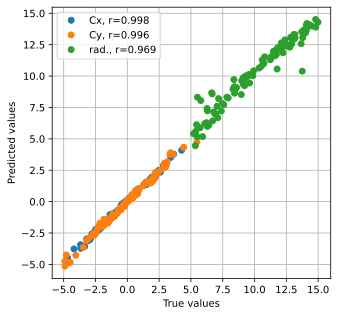

In [14]:
fig = plt.figure(figsize=(5,5))

paramNames = ['Cx','Cy','rad.']

for i in range(3):
  
    # extract parameters and compute correlation
    yy = Y[:,i].detach()
    yh = yHat[:,i].detach()
    cr = np.corrcoef(yy,yh)[0,1]

    # plot with label
    plt.plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')


plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

# Additional explorations

In [ ]:
# 1) Is this model robust to noise? Explore this by increasing the amount of noise added to each stimulus. You can set
#    this up as a parametric experiment if you want, but you can also do it informally, by changing the gain factor of
#    the noise to see whether performance noticeably declines when the images get noisier. Does changing the noise affect
#    the center coordinates or the width more? And what do the results tell you about the power -- or limitations -- of
#    using CNNs for finding features in images?
# 
# 2) You can see from the code that I didn't change the model architecture -- I literally copy/pasted it from the previous
#    Gaussian codes and only added 3 units at the end. Do you think you can develop a different architecture, possibly
#    simpler, that achieves comparable performance while reducing learning time?